# Intro to Causal Structure Learning
***Probabilistic Graphical models*** are *graphical* representations of the structure of conditional (in)depencies among random variables. 

By bridging *probability theory* and *graph theory*, they provide a compact way to visualize the architecture of a model, to motivate the design of new models, and to structure complex probability calculations for performing efficient inference.

We usually distinguish between two types of graphical models:
- **Bayesian Networks**: ideal for modelling *conditional dependencies* between variables; represented by *directed graphs*;
- **Markov Networks**: suitable for modelling *correlations*. In this case the underlying graph is *undirected*.

To learn the directed acyclic graph encoding the causal relationships from the observational data sets, we can use three type of causal structure learning algorithms:
- constraint-based
- score-based 
- NN based algorithms 

# Causal Discovery for NON Linear Additive Noise Models (Non-Linear ANMs)
Non-linear ANMs make the following assumptions: 

* Continouos variables
* Nonlinearity
* Additive noise
* Acyclicity
* No hidden common causes

Denote observed variables by :math:`{x}_{i}` and error variables by :math:`{e}_{i}`. 
The error variables :math:`{e}_{i}` are independent due to the assumption of no hidden common causes. 
Then, mathematically, the model for observed variables :math:`{x}_{i}` is written as 

$$ x_i = f_i (pa(x_i))+e_i, $$

where :math:`{f}_{i}` are some nonlinear (differentiable) functions and :math:`{pa}({x}_{i})` are the parents of :math:`{x}_{i}`.

References

    .. [1] P. O. Hoyer, D. Janzing, J. M. Mooij, and J. Peters. and B. Schölkopf.
       Nonlinear causal discovery with additive noise models.
       Advances in Neural Information Processing Systems 21, pages 689–696. 2009.
    .. [2] J. Peters, J. M. Mooij, D. Janzing, and B. Schölkopf.
       Causal discovery with continuous additive noise models
       Journal of Machine Learning Research, 15: 2009–2053, 2014.

In this tutorial we will use different algorithms available in three libraries in Python to perform causal discovery on Non-Linear ANMs.

The three libraries are:
- gcastle 
- lingam 
- gABI

and they will provide respectively the following algorithms for our problem:
- NOTEARS-MLP, NOTEARS-SOB, GRAN-DAG (gradient-based algorithms using neural network to solve the score optimization problem on the DAG space)
- RESIT, CAM-UV (functional models)
- kernel-PC (constraint-based algorithm with different available CI tests: HSIC-gamma, HSIC-perm, DCC-gamma,RCot)




To install the libraries needed for the causal discovery task,we need first to install the following requirements:
These three libraries have the following requirements:
- scikit-learn>=1.2
- graphviz
- statsmodels
- networkx
- pandas
- pygam
- matplotlib
- psy
- semopy
- tqdm>=4.48.2
- torch>=1.9
- tqdm 
- dask

To make the installation easier I have exported the setting of my conda env into a . yml file "".


In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

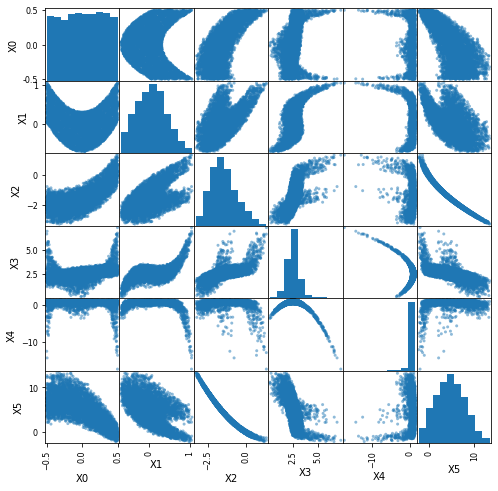

In [2]:
def N(size):
    return np.random.uniform(size=size) - 0.5

n_samples=5000
X = np.zeros([n_samples, 6])
X[:, 0] = N(n_samples)
X[:, 1] = 3 * (X[:, 0] + 0.25) * (X[:, 0] - 0.25) + N(n_samples)
X[:, 2] = -0.75 * (X[:, 0] - 1) * (X[:, 0] - 2) + 1.5 * X[:, 1] + N(n_samples)
X[:, 3] = 5 * (X[:, 1] + 0.4) * (X[:, 1] - 0.1) * (X[:, 1] - 0.5) + 1 * np.log(5 * X[:, 2] + 20) + N(n_samples)
X[:, 4] = -0.8 * (X[:, 3] - 1.5) * (X[:, 3] - 3.5) + N(n_samples)
X[:, 5] = 0.6 * X[:, 2]  * (X[:, 2] - 3.5) + N(n_samples)
X = pd.DataFrame(X, columns=[f'X{i}' for i in range(6)])

pd.plotting.scatter_matrix(X, figsize=(8, 8), alpha=0.5)
plt.show()


In [9]:
m = np.array([
    [0, 0, 0, 0, 0,0],
    [1, 0, 0, 0, 0,0],
    [1, 1, 0, 0, 0,0],
    [0, 1, 1, 0, 0,0],
    [0, 0, 0, 1, 0,0],
    [0,0,1,0,0,0]])

dot = make_dot(m)

# Save pdf
dot.render('dag')

# Save png
dot.format = 'png'
dot.render('dag')



'dag.png'

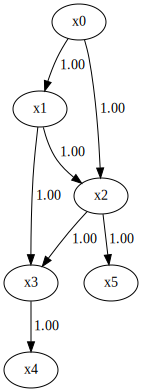

In [5]:
dot

In [11]:
n_sampling = 100

from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(max_depth=4, random_state=0)

model = lingam.RESIT(regressor=reg)
result = model.bootstrap(X, n_sampling=n_sampling)



KeyboardInterrupt: 

In [ ]:
model = lingam.RESIT(regressor=reg)
model.adjacency_matrix_

In [ ]:
cdc = result.get_causal_direction_counts( min_causal_effect=0.01, split_by_causal_effect_sign=True)


# Using gcastle algorithms

In [ ]:
#TESTING ALGORITHMS FOR NON-LINEAR MODELS
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import GraNDAG

# load data
weighted_random_dag = DAG.erdos_renyi(n_nodes=10, n_edges=20,
                                      weight_range=(0.5, 2.0), seed=1)
dataset = IIDSimulation(W=weighted_random_dag, n=2000, method='nonlinear',
                        sem_type='mlp')
dag, x = dataset.B, dataset.X

# Instantiation algorithm
d = {'model_name': 'NonLinGauss', 'nonlinear': 'leaky-relu', 'optimizer': 'sgd', 'norm_prod': 'paths', 'device_type': 'gpu'}
gnd = GraNDAG(input_dim=x.shape[1], )
gnd.learn(data=x)

# plot predict_dag and true_dag
GraphDAG(gnd.causal_matrix, dag)
mm = MetricsDAG(gnd.causal_matrix, dag)
print(mm.metrics)


In [ ]:
from castle.algorithms import NotearsNonlinear
nt = NotearsNonlinear()
nt.learn(x)

# plot est_dag and true_dag
GraphDAG(nt.causal_matrix, dag)

In [ ]:
nt_mm = MetricsDAG(nt.causal_matrix, dag)
print(nt_mm.metrics)

In [ ]:
from castle.algorithms import ICALiNGAM, DirectLiNGAM


#######################################
# ICALiNGAM used simulate data
#######################################
# simulate data for ICALiNGAM
weighted_random_dag = DAG.erdos_renyi(n_nodes=10, n_edges=20, weight_range=(0.5, 2.0), seed=1)
dataset = IIDSimulation(W=weighted_random_dag, n=2000, method='linear', sem_type='gauss')
true_dag, X = dataset.B, dataset.X

# ICALiNGAM learn
g_ICA = ICALiNGAM()
g_ICA.learn(X)

# plot est_dag and true_dag
GraphDAG(g_ICA.causal_matrix, true_dag)

# calculate accuracy
met = MetricsDAG(g_ICA.causal_matrix, true_dag)
print(met.metrics)

g_Direct = DirectLiNGAM()
g_Direct.learn(X)

# plot est_dag and true_dag
GraphDAG(g_Direct.causal_matrix, true_dag)

# calculate accuracy
met = MetricsDAG(g_ICA.causal_matrix, true_dag)
print(met.metrics)

In [12]:
import pickle
import sys
import os
import gc
import time
import networkx as nx
import matplotlib.pyplot as plt
from itertools import chain, combinations, permutations
from coreBN.utils import GAM_residuals, GAM_residuals_fast
#import coreBN
from coreBN.CItests import kernel_CItest_cycle
from coreBN.estimators import kPC as kPC
from coreBN.base import PDAG

In [13]:
data = X
iCI_test= "hsic_gamma"


In [5]:
data_sample= data.head(500)

In [9]:
random_state=42


model=kPC(data=data_sample)
final_pDAG = model.estimate(ci_test=iCI_test,  random_seed= random_state, significance_level=0.05, show_progress=False)

I have created the moral graph
I am reading the data
variables in data: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5']


  0%|          | 0/4 [00:00<?, ?it/s]

I am in variant stable
edge  X0-X4 pval: 0.2974341590938281


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

I am in variant stable
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X2 pval: 0.1622013156385187
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X5 pval: 0.41581331780120045
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X4 pval: 0.7054302476089302
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X5 pval: 0.6705463743060132
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X2-X4 pval: 0.19183032916927134
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X3-X5 pval: 0.8891215121330325
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X4-X5 pval: 0.6277806084520691
I am in variant stable
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X3 pval: 0.513197911428529
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X2 pval: 0.527797137014457
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X3-X4 pval: 0.30712238439288986
EXITING from build_skeleton
AFTER STEP 1:
list nodes in skeleton: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5']
list edges in skeleton: [('X0', 'X1'), ('X1', 'X3'), ('X2', 'X3'), ('X2', 'X5')]
PRINT after call to skeleton to PDAG
list nodes:  ['X1', 'X0', 'X3', 'X2', 'X5']
list directed edges:  set()
list undirected edges:  {('X1', 'X0'), ('X3', 'X2'), ('X0', 'X1'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2'), ('X1', 'X3')}
selected method for CI test is: hsic.gamma
estimating residuals of var: X1
nodes in neighborhood[ X1 ]: ['X0', 'X3']
parents [ X1 ] ['X0', 'X3']
children[ X1 ] ['X0', 'X3']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X0
nodes in neighborhood[ X0 ]: ['X1']
parents [ X0 ] ['X1']
children[ X0 ] ['X1']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X3
nodes in neighborhood[ X3 ]: ['X2', 'X1']
parents [ X3 ] ['X2', 'X1']
children[ X3 ] ['X2', 'X1']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X2
nodes in neighborhood[ X2 ]: ['X3', 'X5']
parents [ X2 ] ['X3', 'X5']
children[ X2 ] ['X3', 'X5']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X5
nodes in neighborhood[ X5 ]: ['X2']
parents [ X5 ] ['X2']
children[ X5 ] ['X2']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


nodes in pdag: ['X1', 'X0', 'X3', 'X2', 'X5']
all edges in pdag: [('X1', 'X0'), ('X1', 'X3'), ('X0', 'X1'), ('X3', 'X2'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2')]
undirected edges in pdag [('X1', 'X0'), ('X3', 'X2'), ('X0', 'X1'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2'), ('X1', 'X3')]
working on edge: X1  -> X0
working on edge: X3  -> X2
working on edge: X0  -> X1
working on edge: X3  -> X1
working on edge: X2  -> X3
working on edge: X2  -> X5
working on edge: X5  -> X2
working on edge: X1  -> X3


In [19]:
random_state=42

def model_bootstrap(data_sample, N_bootstraps=10):
    graphs=[]
    for i in range(N_bootstraps):
        data_resample= data_sample.sample(frac=1, random_state=random_state+1).reset_index()
        data_resample = data_resample.head(200)
        model=kPC(data=data_sample)
        final_pDAG = model.estimate(ci_test=iCI_test,  random_seed= random_state, significance_level=0.05)
        G_last = nx.DiGraph()
        G_last.add_edges_from(final_pDAG.edges()) 
        graphs.append(G_last)
    return graphs
    

    
def create_average_graph(graphs):
    # Initialize an empty graph for the combined edges
    combined_graph = nx.Graph()

    # Aggregate edges from all graphs
    edge_count = {}
    for graph in graphs:
        for u, v in graph.edges():
            if (u, v) not in edge_count and (v, u) not in edge_count:
                edge_count[(u, v)] = 1
            else:
                edge_count[(u, v)] = edge_count.get((u, v), 0) + 1
                edge_count[(v, u)] = edge_count.get((v, u), 0) + 1

    # Add edges to the combined graph with strength attribute
    total_graphs = len(graphs)
    for (u, v), count in edge_count.items():
        strength = count / total_graphs
        combined_graph.add_edge(u, v, strength=strength)

    return combined_graph

def plot_average_graph(graph):
    # Positioning the nodes using a layout (e.g., spring_layout)
    pos = nx.spring_layout(graph)

    # Extract edge strengths
    strengths = [graph[u][v]['strength'] for u, v in graph.edges()]

    # Optional: Normalize edge strengths for better visualization
    max_strength = max(strengths)
    normalized_strengths = [5 * s / max_strength for s in strengths]  # Adjust the multiplier as needed

    # Draw nodes
    nx.draw_networkx_nodes(graph, pos)

    # Draw edges with strength represented as line width
    nx.draw_networkx_edges(graph, pos, width=normalized_strengths)

    # Draw labels
    nx.draw_networkx_labels(graph, pos)

    # Display the plot
    plt.show()

In [ ]:
graphs=model_bootstrap(data_sample, N_bootstraps=10)
average_graph=create_average_graph(graphs)
plot_average_graph(average_graph)

I have created the moral graph
I am reading the data
variables in data: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5']


  0%|          | 0/4 [00:00<?, ?it/s]

I am in variant stable
edge  X0-X4 pval: 0.2974341590938281


 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

I am in variant stable
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X2 pval: 0.1622013156385187
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X5 pval: 0.41581331780120045
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X4 pval: 0.7054302476089302
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X5 pval: 0.6705463743060132
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

edge  X2-X4 pval: 0.19183032916927134
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X3-X5 pval: 0.8891215121330325
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X4-X5 pval: 0.6277806084520691
I am in variant stable
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X3 pval: 0.513197911428529
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X2 pval: 0.527797137014457
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X3-X4 pval: 0.30712238439288986
EXITING from build_skeleton
AFTER STEP 1:
list nodes in skeleton: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5']
list edges in skeleton: [('X0', 'X1'), ('X1', 'X3'), ('X2', 'X3'), ('X2', 'X5')]
PRINT after call to skeleton to PDAG
list nodes:  ['X1', 'X0', 'X3', 'X2', 'X5']
list directed edges:  set()
list undirected edges:  {('X1', 'X0'), ('X3', 'X2'), ('X0', 'X1'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2'), ('X1', 'X3')}
selected method for CI test is: hsic.gamma
estimating residuals of var: X1
nodes in neighborhood[ X1 ]: ['X0', 'X3']
parents [ X1 ] ['X0', 'X3']
children[ X1 ] ['X0', 'X3']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X0
nodes in neighborhood[ X0 ]: ['X1']
parents [ X0 ] ['X1']
children[ X0 ] ['X1']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X3
nodes in neighborhood[ X3 ]: ['X2', 'X1']
parents [ X3 ] ['X2', 'X1']
children[ X3 ] ['X2', 'X1']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X2
nodes in neighborhood[ X2 ]: ['X3', 'X5']
parents [ X2 ] ['X3', 'X5']
children[ X2 ] ['X3', 'X5']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X5
nodes in neighborhood[ X5 ]: ['X2']
parents [ X5 ] ['X2']
children[ X5 ] ['X2']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


nodes in pdag: ['X1', 'X0', 'X3', 'X2', 'X5']
all edges in pdag: [('X1', 'X0'), ('X1', 'X3'), ('X0', 'X1'), ('X3', 'X2'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2')]
undirected edges in pdag [('X1', 'X0'), ('X3', 'X2'), ('X0', 'X1'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2'), ('X1', 'X3')]
working on edge: X1  -> X0
working on edge: X3  -> X2
working on edge: X0  -> X1
working on edge: X3  -> X1
working on edge: X2  -> X3
working on edge: X2  -> X5
working on edge: X5  -> X2
working on edge: X1  -> X3
I have created the moral graph
I am reading the data
variables in data: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5']


  0%|          | 0/4 [00:00<?, ?it/s]

I am in variant stable
edge  X0-X4 pval: 0.2974341590938281


 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

I am in variant stable
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X2 pval: 0.1622013156385187
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X5 pval: 0.41581331780120045
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:  00:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X4 pval: 0.7054302476089302
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X5 pval: 0.6705463743060132
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X2-X4 pval: 0.19183032916927134
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X3-X5 pval: 0.8891215121330325
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X4-X5 pval: 0.6277806084520691
I am in variant stable
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X3 pval: 0.513197911428529
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X2 pval: 0.527797137014457
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X3-X4 pval: 0.30712238439288986
EXITING from build_skeleton
AFTER STEP 1:
list nodes in skeleton: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5']
list edges in skeleton: [('X0', 'X1'), ('X1', 'X3'), ('X2', 'X3'), ('X2', 'X5')]
PRINT after call to skeleton to PDAG
list nodes:  ['X1', 'X0', 'X3', 'X2', 'X5']
list directed edges:  set()
list undirected edges:  {('X1', 'X0'), ('X3', 'X2'), ('X0', 'X1'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2'), ('X1', 'X3')}
selected method for CI test is: hsic.gamma
estimating residuals of var: X1
nodes in neighborhood[ X1 ]: ['X0', 'X3']
parents [ X1 ] ['X0', 'X3']
children[ X1 ] ['X0', 'X3']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X0
nodes in neighborhood[ X0 ]: ['X1']
parents [ X0 ] ['X1']
children[ X0 ] ['X1']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X3
nodes in neighborhood[ X3 ]: ['X2', 'X1']
parents [ X3 ] ['X2', 'X1']
children[ X3 ] ['X2', 'X1']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

estimating residuals of var: X2
nodes in neighborhood[ X2 ]: ['X3', 'X5']
parents [ X2 ] ['X3', 'X5']
children[ X2 ] ['X3', 'X5']


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X5
nodes in neighborhood[ X5 ]: ['X2']
parents [ X5 ] ['X2']
children[ X5 ] ['X2']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


nodes in pdag: ['X1', 'X0', 'X3', 'X2', 'X5']
all edges in pdag: [('X1', 'X0'), ('X1', 'X3'), ('X0', 'X1'), ('X3', 'X2'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2')]
undirected edges in pdag [('X1', 'X0'), ('X3', 'X2'), ('X0', 'X1'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2'), ('X1', 'X3')]
working on edge: X1  -> X0
working on edge: X3  -> X2
working on edge: X0  -> X1
working on edge: X3  -> X1
working on edge: X2  -> X3
working on edge: X2  -> X5
working on edge: X5  -> X2
working on edge: X1  -> X3
I have created the moral graph
I am reading the data
variables in data: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5']


  0%|          | 0/4 [00:00<?, ?it/s]

I am in variant stable
edge  X0-X4 pval: 0.2974341590938281


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

I am in variant stable
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X2 pval: 0.1622013156385187
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X5 pval: 0.41581331780120045
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X4 pval: 0.7054302476089302
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

edge  X1-X5 pval: 0.6705463743060132
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

edge  X2-X4 pval: 0.19183032916927134
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X3-X5 pval: 0.8891215121330325
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X4-X5 pval: 0.6277806084520691
I am in variant stable
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X3 pval: 0.513197911428529
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X2 pval: 0.527797137014457
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X3-X4 pval: 0.30712238439288986
EXITING from build_skeleton
AFTER STEP 1:
list nodes in skeleton: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5']
list edges in skeleton: [('X0', 'X1'), ('X1', 'X3'), ('X2', 'X3'), ('X2', 'X5')]
PRINT after call to skeleton to PDAG
list nodes:  ['X1', 'X0', 'X3', 'X2', 'X5']
list directed edges:  set()
list undirected edges:  {('X1', 'X0'), ('X3', 'X2'), ('X0', 'X1'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2'), ('X1', 'X3')}
selected method for CI test is: hsic.gamma
estimating residuals of var: X1
nodes in neighborhood[ X1 ]: ['X0', 'X3']
parents [ X1 ] ['X0', 'X3']
children[ X1 ] ['X0', 'X3']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X0
nodes in neighborhood[ X0 ]: ['X1']
parents [ X0 ] ['X1']
children[ X0 ] ['X1']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X3
nodes in neighborhood[ X3 ]: ['X2', 'X1']
parents [ X3 ] ['X2', 'X1']
children[ X3 ] ['X2', 'X1']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X2
nodes in neighborhood[ X2 ]: ['X3', 'X5']
parents [ X2 ] ['X3', 'X5']
children[ X2 ] ['X3', 'X5']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X5
nodes in neighborhood[ X5 ]: ['X2']
parents [ X5 ] ['X2']
children[ X5 ] ['X2']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


nodes in pdag: ['X1', 'X0', 'X3', 'X2', 'X5']
all edges in pdag: [('X1', 'X0'), ('X1', 'X3'), ('X0', 'X1'), ('X3', 'X2'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2')]
undirected edges in pdag [('X1', 'X0'), ('X3', 'X2'), ('X0', 'X1'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2'), ('X1', 'X3')]
working on edge: X1  -> X0
working on edge: X3  -> X2
working on edge: X0  -> X1
working on edge: X3  -> X1
working on edge: X2  -> X3
working on edge: X2  -> X5
working on edge: X5  -> X2
working on edge: X1  -> X3
I have created the moral graph
I am reading the data
variables in data: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5']


  0%|          | 0/4 [00:00<?, ?it/s]

I am in variant stable
edge  X0-X4 pval: 0.2974341590938281


 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

I am in variant stable
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X2 pval: 0.1622013156385187
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X5 pval: 0.41581331780120045
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X4 pval: 0.7054302476089302
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X5 pval: 0.6705463743060132
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X2-X4 pval: 0.19183032916927134
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

edge  X3-X5 pval: 0.8891215121330325
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X4-X5 pval: 0.6277806084520691
I am in variant stable
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X3 pval: 0.513197911428529
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X2 pval: 0.527797137014457
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X3-X4 pval: 0.30712238439288986
EXITING from build_skeleton
AFTER STEP 1:
list nodes in skeleton: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5']
list edges in skeleton: [('X0', 'X1'), ('X1', 'X3'), ('X2', 'X3'), ('X2', 'X5')]
PRINT after call to skeleton to PDAG
list nodes:  ['X1', 'X0', 'X3', 'X2', 'X5']
list directed edges:  set()
list undirected edges:  {('X1', 'X0'), ('X3', 'X2'), ('X0', 'X1'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2'), ('X1', 'X3')}
selected method for CI test is: hsic.gamma
estimating residuals of var: X1
nodes in neighborhood[ X1 ]: ['X0', 'X3']
parents [ X1 ] ['X0', 'X3']
children[ X1 ] ['X0', 'X3']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X0
nodes in neighborhood[ X0 ]: ['X1']
parents [ X0 ] ['X1']
children[ X0 ] ['X1']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X3
nodes in neighborhood[ X3 ]: ['X2', 'X1']
parents [ X3 ] ['X2', 'X1']
children[ X3 ] ['X2', 'X1']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X2
nodes in neighborhood[ X2 ]: ['X3', 'X5']
parents [ X2 ] ['X3', 'X5']
children[ X2 ] ['X3', 'X5']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X5
nodes in neighborhood[ X5 ]: ['X2']
parents [ X5 ] ['X2']
children[ X5 ] ['X2']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


nodes in pdag: ['X1', 'X0', 'X3', 'X2', 'X5']
all edges in pdag: [('X1', 'X0'), ('X1', 'X3'), ('X0', 'X1'), ('X3', 'X2'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2')]
undirected edges in pdag [('X1', 'X0'), ('X3', 'X2'), ('X0', 'X1'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2'), ('X1', 'X3')]
working on edge: X1  -> X0
working on edge: X3  -> X2
working on edge: X0  -> X1
working on edge: X3  -> X1
working on edge: X2  -> X3
working on edge: X2  -> X5
working on edge: X5  -> X2
working on edge: X1  -> X3
I have created the moral graph
I am reading the data
variables in data: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5']


  0%|          | 0/4 [00:00<?, ?it/s]

I am in variant stable
edge  X0-X4 pval: 0.2974341590938281


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

I am in variant stable
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

edge  X0-X2 pval: 0.1622013156385187
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X5 pval: 0.41581331780120045
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X4 pval: 0.7054302476089302
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X5 pval: 0.6705463743060132
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X2-X4 pval: 0.19183032916927134
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

edge  X3-X5 pval: 0.8891215121330325
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X4-X5 pval: 0.6277806084520691
I am in variant stable
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X3 pval: 0.513197911428529
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X2 pval: 0.527797137014457
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X3-X4 pval: 0.30712238439288986
EXITING from build_skeleton
AFTER STEP 1:
list nodes in skeleton: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5']
list edges in skeleton: [('X0', 'X1'), ('X1', 'X3'), ('X2', 'X3'), ('X2', 'X5')]
PRINT after call to skeleton to PDAG
list nodes:  ['X1', 'X0', 'X3', 'X2', 'X5']
list directed edges:  set()
list undirected edges:  {('X1', 'X0'), ('X3', 'X2'), ('X0', 'X1'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2'), ('X1', 'X3')}
selected method for CI test is: hsic.gamma
estimating residuals of var: X1
nodes in neighborhood[ X1 ]: ['X0', 'X3']
parents [ X1 ] ['X0', 'X3']
children[ X1 ] ['X0', 'X3']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X0
nodes in neighborhood[ X0 ]: ['X1']
parents [ X0 ] ['X1']
children[ X0 ] ['X1']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X3
nodes in neighborhood[ X3 ]: ['X2', 'X1']
parents [ X3 ] ['X2', 'X1']
children[ X3 ] ['X2', 'X1']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X2
nodes in neighborhood[ X2 ]: ['X3', 'X5']
parents [ X2 ] ['X3', 'X5']
children[ X2 ] ['X3', 'X5']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

estimating residuals of var: X5
nodes in neighborhood[ X5 ]: ['X2']
parents [ X5 ] ['X2']
children[ X5 ] ['X2']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


nodes in pdag: ['X1', 'X0', 'X3', 'X2', 'X5']
all edges in pdag: [('X1', 'X0'), ('X1', 'X3'), ('X0', 'X1'), ('X3', 'X2'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2')]
undirected edges in pdag [('X1', 'X0'), ('X3', 'X2'), ('X0', 'X1'), ('X3', 'X1'), ('X2', 'X3'), ('X2', 'X5'), ('X5', 'X2'), ('X1', 'X3')]
working on edge: X1  -> X0
working on edge: X3  -> X2
working on edge: X0  -> X1
working on edge: X3  -> X1
working on edge: X2  -> X3
working on edge: X2  -> X5
working on edge: X5  -> X2
working on edge: X1  -> X3
I have created the moral graph
I am reading the data
variables in data: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5']


  0%|          | 0/4 [00:00<?, ?it/s]

I am in variant stable
edge  X0-X4 pval: 0.2974341590938281


 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

I am in variant stable
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X2 pval: 0.1622013156385187
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X0-X5 pval: 0.41581331780120045
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X4 pval: 0.7054302476089302
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X1-X5 pval: 0.6705463743060132
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

edge  X2-X4 pval: 0.19183032916927134
<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

<class 'list'>


In [11]:
# %% Make plot
def plot(G, node_color=None, node_size=1500, node_size_scale=[80, 1000], alpha=0.8, font_size=16, cmap='Set2', width=25, height=25, pos=None, filename=None, title=None, methodtype='circular', layout='circular_layout', verbose=3):
    # https://networkx.github.io/documentation/networkx-1.7/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html
    config = {}
    config['filename']=filename
    config['width']=width
    config['height']=height
    config['verbose']=verbose
    config['node_size_scale']=node_size_scale

    if verbose>=3: print('[gABiC] >Creating network plot')

    ##### DEPRECATED IN LATER VERSION #####
    if methodtype is not None:
        if verbose>=2: print('[gABiC] >Methodtype will be removed in future version. Please use "layout" instead')
        if methodtype=='circular':
            layout = 'draw_circular'
        elif methodtype=='kawai':
            layout = 'draw_kamada_kawai'
        else:
            layout = 'spring_layout'
    ##### END BLOCK #####

    if 'pandas' in str(type(node_size)):
        node_size=node_size.values

    # scaling node sizes
    if config['node_size_scale']!=None and 'numpy' in str(type(node_size)):
        if verbose>=3: print('[gABiC] >Scaling node sizes')
        node_size=minmax_scale(node_size, feature_range=(node_size_scale[0], node_size_scale[1]))

    # Setup figure
    fig = plt.figure(figsize=(config['width'], config['height']))

    # Make the graph
    try:
        # Get the layout
        layout_func = getattr(nx, layout)
        layout_func(G, labels=node_label, node_size=1000, alhpa=alpha, node_color=node_color, cmap=cmap, font_size=font_size, with_labels=True)
    except:
        if verbose>=2: print('[gABiC] >Warning: [%s] layout not found. The [spring_layout] is used instead.' %(layout))
        #nx.spring_layout(G, labels=node_label, pos=pos, node_size=node_size, alhpa=alpha, node_color=node_color, cmap=cmap, font_size=font_size, with_labels=True)
    if methodtype=='graphviz':
       pos_viz = nx.nx_agraph.graphviz_layout(G, prog="dot")
       nx.draw(G, pos=pos_viz , node_size=1000, alpha=0.7, node_color='white', edgecolors="black", font_size=16, with_labels=True)
    if methodtype=='spring':
       nx.draw(G, pos=nx.spring_layout(G), node_size=node_size, alpha=alpha, node_color='white', edgecolors="black", font_size=font_size, with_labels=True)

    if methodtype=='circular':
       nx.draw(G, pos=nx.circular_layout(G), node_size=node_size, alpha=alpha, node_color=node_color, cmap=cmap, font_size=font_size, with_labels=True)
    elif methodtype=='kawai':
       nx.draw(G, pos=nx.kamada_kawai_layout(G), node_size=node_size, alpha=alpha, node_color='white', edgecolors="black", font_size=font_size, with_labels=True)
    #     nx.draw_kamada_kawai(G, labels=node_label, node_size=node_size, alhpa=alpha, node_color=node_color, cmap=cmap, font_size=font_size, with_labels=True)
    # else:
        # nx.draw_networkx(G, labels=node_label, pos=pos, node_size=node_size, alhpa=alpha, node_color=node_color, cmap=cmap, font_size=font_size, with_labels=True)

    plt.title(title)
    plt.grid(True)
    plt.show()

    # Savefig
    if not isinstance(config['filename'], type(None)):
        if verbose>=3: print('[gABiC] >Saving figure')
        plt.savefig(config['filename'])

    return(fig)


In [10]:

final_pDAG.edges()

OutEdgeView([('X3', 'X2'), ('X2', 'X5'), ('X0', 'X1'), ('X1', 'X3')])

[gABiC] >Creating network plot
[gABiC] >Methodtype will be removed in future version. Please use "layout" instead
[gABiC] >Warning: [spring_layout] layout not found. The [spring_layout] is used instead.


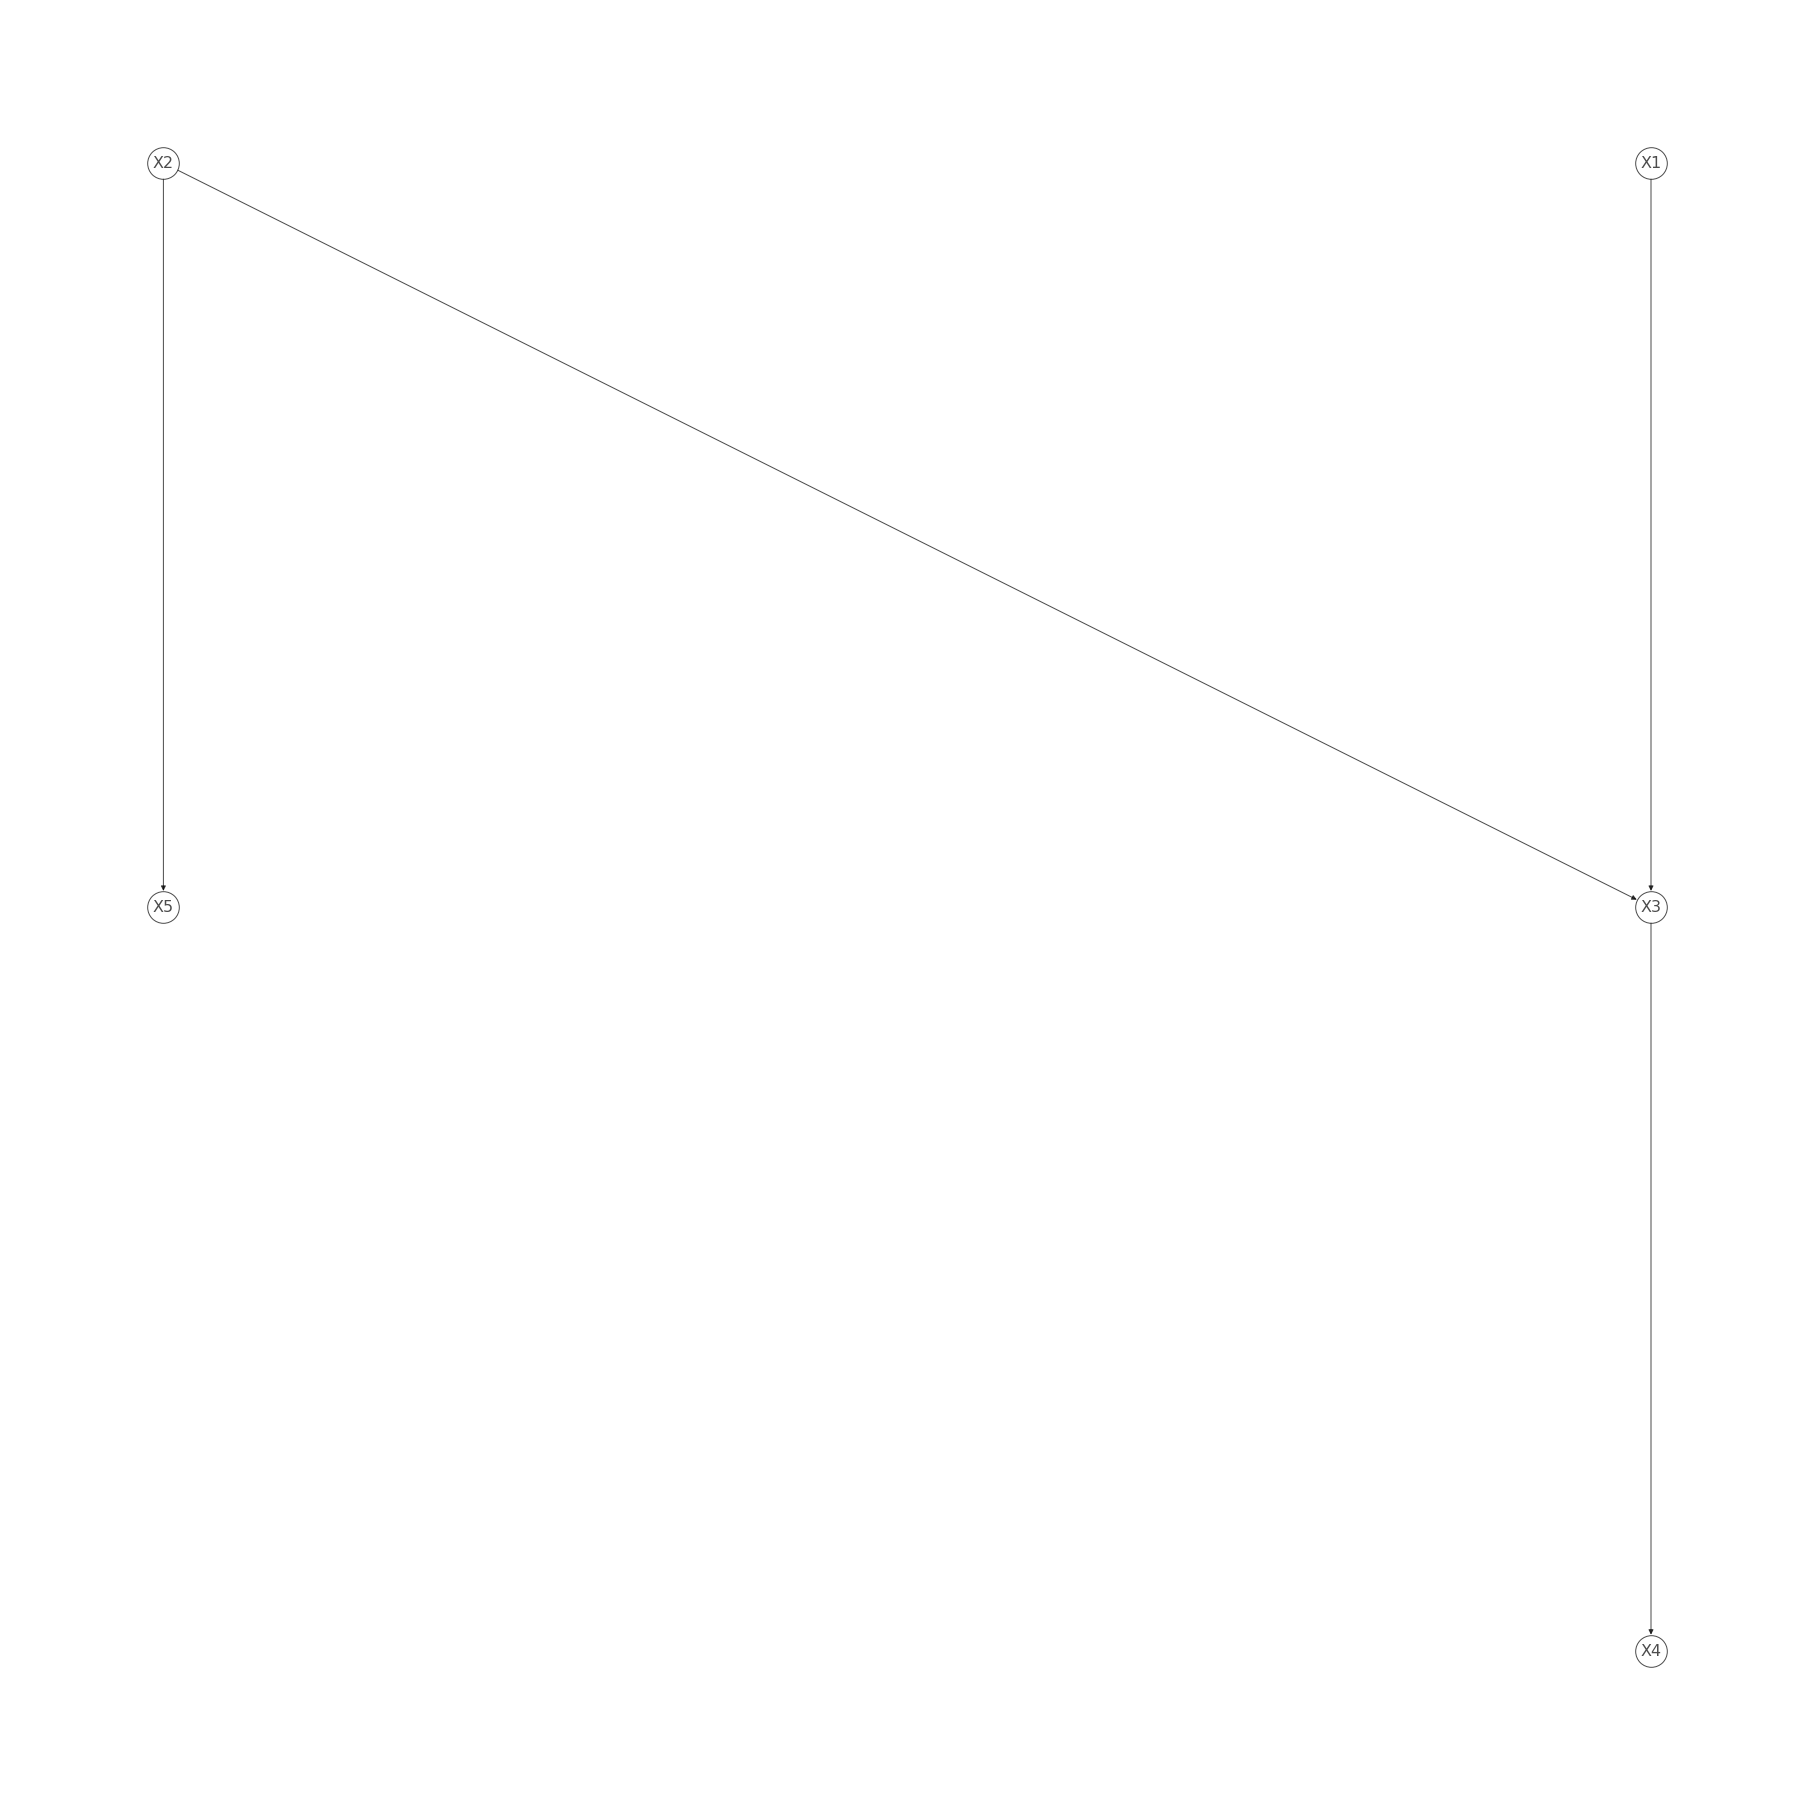

[gABiC] >Saving figure


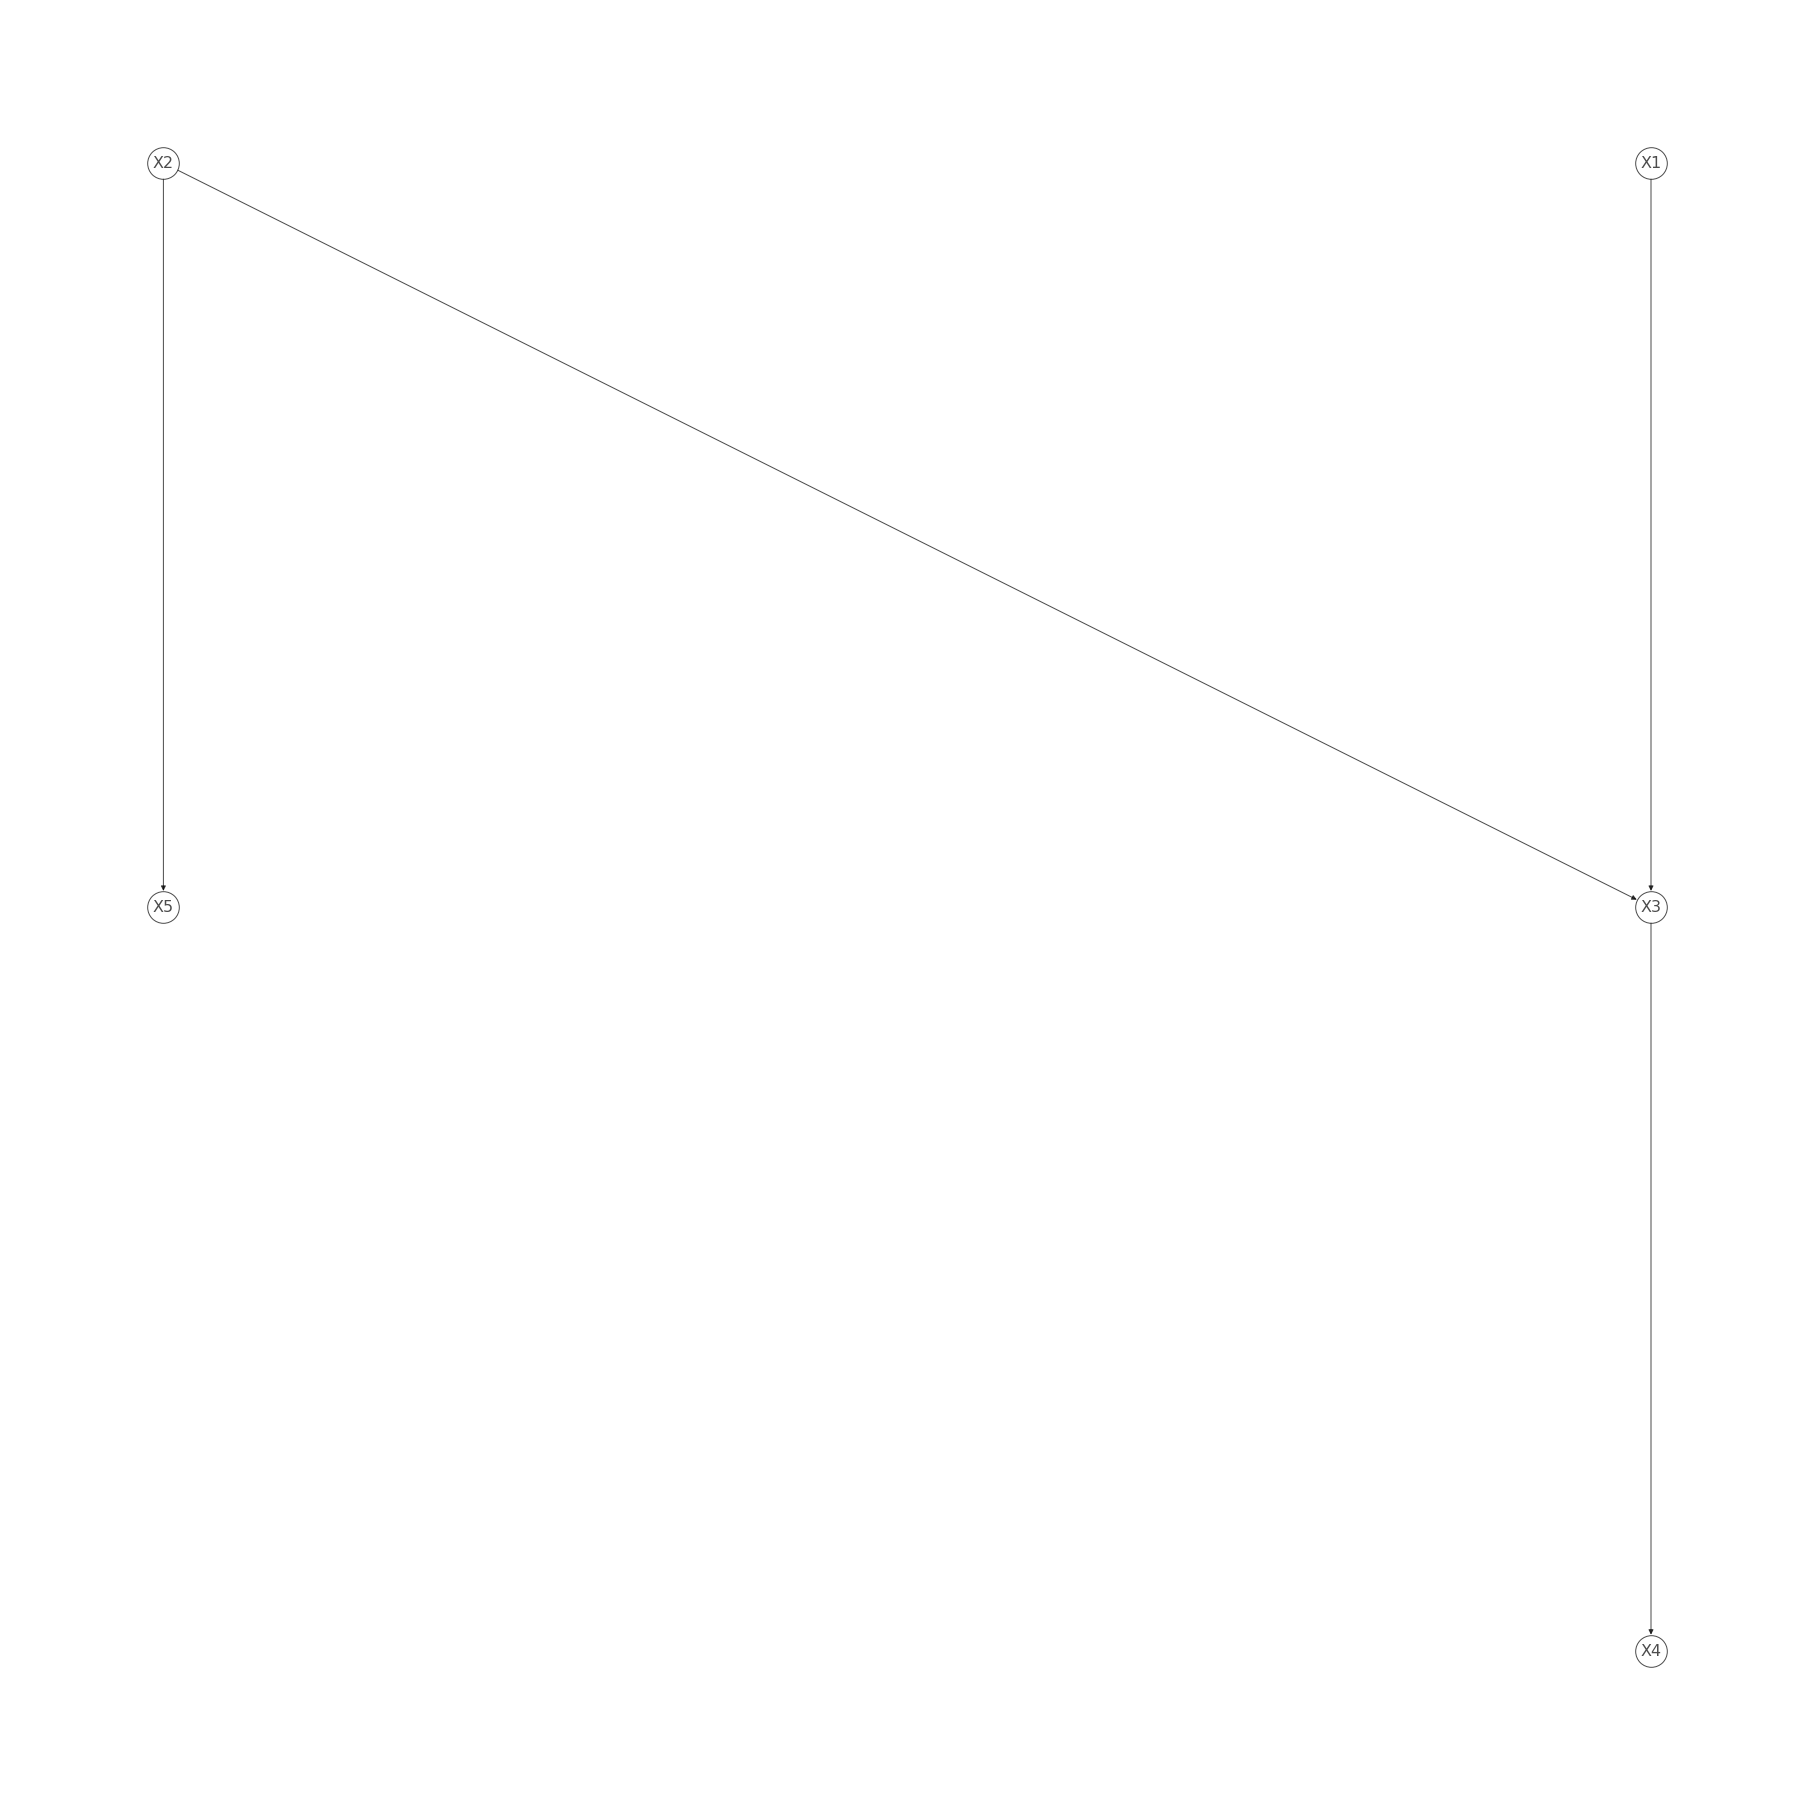

<Figure size 432x288 with 0 Axes>

In [23]:
G_last = nx.DiGraph()

G_last.add_edges_from(final_pDAG.edges())  

plot(G_last, methodtype='graphviz', filename="base_DAG.png") 